In [1]:
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 135, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 55, 15)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

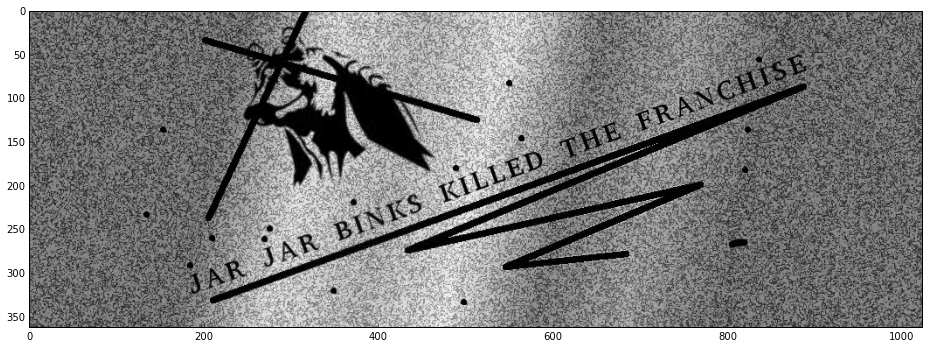

In [2]:
from IPython.html import widgets
from IPython.html.widgets import interactive
from IPython.display import display
image=load_image('images/slika_test.jpg')
height, width = image.shape[0:2]
# ndarray je n-dimensional array, odnosno n-dimenzionalna matrica. Grayscale slika nema RGB, 
# vec samo intenzitet piksela (0 je crno, 255 je belo, sve ostalo izmedju je nijansa sive).
# Sa dtype=np.uint8 se naglasava da je u pitanju 8-bitni tip podatka za elemente matrice, tj. piksele
image_gr = np.ndarray((height, width), dtype=np.uint8)


def rgb(r,g,b):
    for i in range(0, height):
        for j in range(0, width):
            pixel = image[i, j] # preuzimanje piksela
            re,gr,bl = pixel[0], pixel[1], pixel[2] # preuzimanje RGB komponenti piksela
            gray = float(re) * r + float(gr) * g + float(bl) *b # racunanje grayscale intenziteta
            image_gr[i, j] = gray # postavljanje piksela na rezultujucoj slici

    plt.imshow(image_gr, 'gray')

r_slider = widgets.FloatSliderWidget(min=0,max=1,value=0.5,step=0.001)
g_slider = widgets.FloatSliderWidget(min=0,max=1,value=0.5,step=0.001)
b_slider = widgets.FloatSliderWidget(min=0,max=1,value=0.5,step=0.001)
w = widgets.interactive(rgb, r=r_slider, g=g_slider, b=b_slider)
display(w)

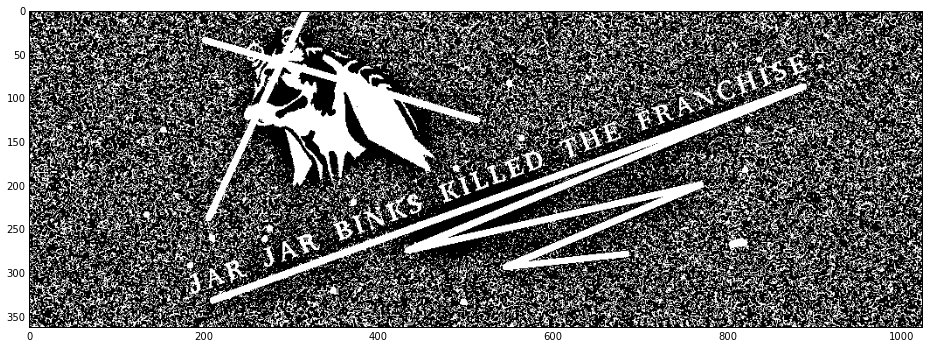

In [27]:
from scipy import signal
gx = [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]]

gy = [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]]

image_gx = signal.convolve2d(image_gr, gx)
image_gy = signal.convolve2d(image_gr, gy)
image_sobel = np.sqrt(image_gx*image_gx + image_gy*image_gy)
plt.imshow(image_sobel, 'gray')

image_b= image_bin_adaptive(image_gr)
image_b =invert((image_b))
display_image(image_b)

In [28]:
#Slajderi za treshold
from IPython.html import widgets
from IPython.html.widgets import interactive
from IPython.display import display



def treshold(p,d,t):
    image_b = cv2.adaptiveThreshold(image_b, p, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, d, t)
    #image_b=cv2.threshold(image_gr, p, d, cv2.THRESH_BINARY)
    image_b = invert(image_b)
    display_image(image_b)
    
p_slider = widgets.IntSliderWidget(min=0,max=500,value=255,step=3)
d_slider = widgets.IntSliderWidget(min=0,max=100,value=15,step=1)
t_slider = widgets.IntSliderWidget(min=0,max=80,value=10,step=1)
w = widgets.interactive(treshold, p=p_slider, d=d_slider, t=t_slider)
display(w)


UnboundLocalError: local variable 'image_b' referenced before assignment

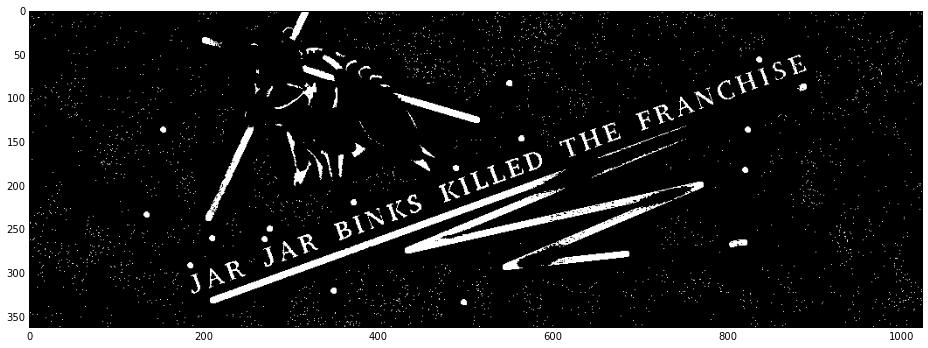

In [9]:
image_b = cv2.adaptiveThreshold(image_gr, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, 67)
image_b = invert(((image_b)))
display_image(image_b)

In [22]:
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            #TODO 1 - izračunati koordinate tačke nakon rotacije
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

def select_roi(image_orig, image_bin):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contours_sb = []
    for contour in contours_borders:
        area = cv2.contourArea(contour)
        if area > 100 and area < 200:
            contours_sb.append(contour)


    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_sb:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,h,w = cv2.boundingRect(contour)
        if xt<10 and yt<20:
            region_points = []
            for i in range (xt,xt+h):
                for j in range(yt,yt+w):
                    dist = cv2.pointPolygonTest(contour,(i,j),False)
                    if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                        region_points.append([i,j])
            cv2.rectangle(image_orig,(xt,yt),(xt+w,yt+h),(0,255,0),2)            
            contour_centers.append(center)
            contour_angles.append(angle)
            contour_sizes.append(size)
            contours.append(region_points)
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    #spajanje kukica i kvacica
    #contours = merge_regions(contours)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

In [23]:
sele_reg, slova, distances=select_roi(image.copy(), image_b)
display_image(sele_reg)
print len(slova)

IndexError: too many indices for array